## Building an Crypto/DeFi Arbitrage Agent using LangGraph

A LangGraph agent that researches cryptocurrencies and their current pair price (e.g USD/BTC, ETH/BTC, etc.), extracts exchange information where token pair is available for trading, and then identifies opportunities for buying/selling the difference between one exchange's price and another.

Context: Since the price evaluation for every cryptocurrency pair is evaluated in a decentralized manner, there is generally price drift/difference between different exchanges, especially for lower market cap & lower volume coins. This creates opportunities for buying a coin at a low price on one exchange and then selling it at a higher price elsewhere to pocket the difference.

### Import Necessary Libraries

In [25]:
%pip install gradio langgraph langchain_core langchain_groq langchain_community tavily_python pydantic pycoingecko

Note: you may need to restart the kernel to use updated packages.


In [26]:
from typing import Dict, TypedDict, List, Optional, Annotated, Any
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from pydantic import BaseModel, RootModel
from pycoingecko import CoinGeckoAPI
from tavily import TavilyClient

from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os, re, json, uuid, requests, time

from operator import add

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["COINGECKO_API_KEY"] = os.getenv("COINGECKO_API_KEY")


### Define State Structure

In [27]:
class ResearchState(TypedDict):
    query: Annotated[str, "The user's query. May include multiple tickers/pairs (e.g., BTC/USD, ETH/USD)."]
    refinement_count: Annotated[int, "Number of refinement loops executed"]
    research_iteration: Annotated[int, "Total passes through core research loop"]
    coin_summary: Annotated[str, "LLM-written concise overview integrating refinements"]
    
    symbols: Annotated[List[str], "Extracted cryptocurrency symbols"]
    coin_ids: Annotated[Dict[str, str], "Mapping of symbols to CoinGecko IDs"]
    parsed_coins: Annotated[List[Dict[str, str]], "List of parsed coins with symbol and ID"]

    web_queries: Annotated[List[str], "3-5 high-signal Tavily queries"]
    web_data: Annotated[List[Dict[str, Any]], "Normalized Tavily results (title, url, content)", add]
    web_summary: Annotated[str, "LLM risk and trustworthiness summary for exchanges", add]

    exchange_queries: Annotated[List[str], "Queries to drive exchange data gathering"]
    exchange_data: Annotated[List[Dict[str, Any]], "Per-symbol market and exchange snapshots", add]
    exchange_summary: Annotated[str, "LLM summary: spread, liquidity, and suggested 2 exchanges per pair"]
    exchange_summary_texts: Annotated[List[str], "List of LLM exchange summary outputs to avoid concurrent writes", add]
    exchange_suggestions: Annotated[Dict[str, Any], "Structured best-pair suggestions per symbol: {symbol: {exA, exB, spread, volume, reason}}"]
    avoid_low_trust_exchanges: Annotated[bool, "If true, exclude non-green trust exchanges"]

    memory_window: Annotated[List[str], "Rolling window of latest notes", add]

    arbitrage_score: Annotated[float, "0-1 score for arbitrage potential"]
    risk_level: Annotated[str, "low|medium|high"]
    decision: Annotated[str, "adequate_report|inadequate_report"]
    report_score: Annotated[float, "0-1 quality score for the arbitrage report"]
    report: Annotated[str, "Final arbitrage report"]
    refinement_feedback: Annotated[str, "Critique/instructions from last refinement step" , add]
    human_decision: Annotated[str, "approve|reject"]


class ArbitrageState(TypedDict):
    query: Annotated[str, "The user's query"]
    # Surface research subgraph outputs so they are preserved in parent state
    decision: Annotated[str, "adequate_potential|inadequate_potential|exchange_risk_too_high"]
    risk_level: Annotated[str, "low|medium|high"]
    arbitrage_score: Annotated[float, "0-1 score for arbitrage potential"]
    exchange_suggestions: Annotated[Dict[str, Any], "Best per-symbol arbitrage suggestions"]
    report: Annotated[str, "Research subgraph arbitrage report"]
    human_decision: Annotated[str, "approve|reject"]

    # Parent node LLM summary
    arbitrage_report: Annotated[str, "An LLM-written profit assessment summary for the user"]
    

### Define Data Structs

In [28]:
class WebItem(BaseModel):
    title: str
    url: str
    content: str

class ExchangeTicker(BaseModel):
    symbol: str
    coin_id: Optional[str] = None
    exchange: str
    pair: str
    price: Optional[float] = None
    volume: Optional[float] = None
    trust: Optional[str] = None
    spread_pct: Optional[float] = None

class ExchangeSuggestion(BaseModel):
    symbol: str
    pair: str
    exchange_buy: str
    exchange_sell: str
    buy_price: Optional[float]
    sell_price: Optional[float]
    price_diff: float
    volume_sum: float
    spread_penalty: float
    trust: List[Optional[str]]
    score: float

class ExchangeSuggestions(RootModel[Dict[str, ExchangeSuggestion]]):
    def to_dict(self) -> Dict[str, Dict[str, Any]]:
        return {k: v.model_dump() for k, v in self.__root__.items()}


In [29]:
MAX_COIN_REFINEMENT = 3
MAX_RESEARCH_ITERATIONS = 3
MAX_REPORT_REFINEMENT = 3
MEMORY_WINDOW_SIZE = 5 
ADEQUATE_REPORT_SCORE= 0.5

coingecko_api_key = os.getenv("COINGECKO_API_KEY")
if coingecko_api_key and coingecko_api_key != "your_coingecko_api_key_here":
    cg = CoinGeckoAPI(demo_api_key=coingecko_api_key)
    print(f"CoinGecko API initialized with key!")
else:
    cg = CoinGeckoAPI()
    print("CoinGecko API initialized without API key (using free tier)")

try:
    cg.ping()
    print("Successfully connected to CoinGecko API.")
except Exception as e:
    print(f"Could not connect to CoinGecko API: {e}")

tavily_client = None
if TavilyClient and os.getenv("TAVILY_API_KEY"):
    try:
        tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    except Exception:
        print("Error initializing TavilyClient API key")

research_model_name = "llama-3.1-8b-instant"
assessment_model_name = "llama-3.1-8b-instant"

research_llm = ChatGroq(model=research_model_name, temperature=0.9)
assessment_llm = ChatGroq(model=assessment_model_name, temperature=0.0)

CoinGecko API initialized with key!
Successfully connected to CoinGecko API.


### Define Node Functions

##### Research Graph functions

In [30]:
def human_approval(state: ResearchState) -> ResearchState:
    decision_raw = state.get("human_decision", "approve")
    decision_norm = str(decision_raw).strip().lower()
    if decision_norm in {"y", "yes", "approved", "approve", "true", "1"}:
        decision = "approve"
    elif decision_norm in {"n", "no", "rejected", "reject", "false", "0"}:
        decision = "reject"
    else:
        decision = "approve"
    return {"human_decision": decision}


def write_coin_summarization(state: ResearchState) -> ResearchState:
    it = int(state.get("research_iteration", 0)) + 1
    if it > MAX_RESEARCH_ITERATIONS:
        print(f"SAFETY: Reached max iterations ({MAX_RESEARCH_ITERATIONS}). Stopping.")
        return {
            "coin_summary": "Iteration cap reached. Stopping refinements.",
            "refinement_count": int(state.get("refinement_count", 0)),
            "research_iteration": it,
            "memory_window": [f"Iteration {it}: cap reached"][-MEMORY_WINDOW_SIZE:],
        }

    query = state.get("query", "")
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a senior crypto research analyst. Your task is to provide a detailed, exploratory overview of the coins mentioned in the user's query. Go beyond the surface level. Consider tokenomics, recent news and developments, potential risks, and the overall market sentiment. Identify key data points that will be crucial for determining arbitrage opportunities."),
        ("human", "User Query: {query}. Please provide an exploratory analysis covering the aspects mentioned above. Be thorough and detailed."),
    ])
    chain = prompt | research_llm
    
    try:
        resp = chain.invoke({"query": query})
        note = f"Iter {it}: summarized {query[:60]}..."
        return {
            "coin_summary": resp.content if hasattr(resp, "content") else str(resp),
            "refinement_count": int(state.get("refinement_count", 0)),
            "research_iteration": it,
            "memory_window": (state.get("memory_window", []) + [note])[-MEMORY_WINDOW_SIZE:],
        }
    except Exception:
        note = f"Iter {it}: fallback summary"
        return {
            "coin_summary": f"Coin research summary for query: {query}",
            "refinement_count": int(state.get("refinement_count", 0)),
            "research_iteration": it,
            "memory_window": (state.get("memory_window", []) + [note])[-MEMORY_WINDOW_SIZE:],
        }


def coin_name_conversion(state: ResearchState) -> dict:
    """Converts cryptocurrency names in a query to ticker symbols using an LLM."""
    query = state.get("query", "")
    try:
        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful assistant that converts cryptocurrency names to their ticker symbols. From the user query, identify any cryptocurrency names and provide their corresponding tickers. Your output should be an extremely simple JSON array of uppercase ticker symbols, like [\"BTC\", \"LTC\"]. Do not include any explanations or other text."),
            ("human", "User Query: {query}")
        ])
        chain = prompt | assessment_llm
        resp = chain.invoke({"query": query})
        
        text = resp.content if hasattr(resp, "content") else str(resp)
        start = text.find("[")
        end = text.rfind("]")
        if start != -1 and end != -1:
            json_text = text[start:end+1]
            symbols = json.loads(json_text)
            if isinstance(symbols, list) and all(isinstance(s, str) for s in symbols):
                print(f"Converted coin names to tickers: {symbols}")
                # Return a dictionary with the key "symbols"
                return {"symbols": [s.upper() for s in symbols]}
    except Exception as e:
        print(f"Could not convert coin names to tickers: {e}")
    # Return a dictionary with an empty list if conversion fails
    return {"symbols": []}

def parse_coins(state: ResearchState) -> ResearchState:
    """
    Map symbols produced by coin_name_conversion to CoinGecko IDs.
    Do NOT call coin_name_conversion here. This node only maps existing symbols.
    """
    symbols = state.get("symbols", [])
    existing_coin_ids = state.get("coin_ids", {}) or {}
    
    print(f"\nPARSE_COINS: START - symbols={symbols}, existing_coin_ids keys={list(existing_coin_ids.keys())}")

    if not symbols:
        print("\nPARSE_COINS: No symbols to map (did coin_name_conversion run?)")
        return {"coin_ids": {}, "parsed_coins": []}

    # If we already have IDs for all symbols, keep them
    if symbols and existing_coin_ids and all(sym in existing_coin_ids for sym in symbols):
        parsed = [{"symbol": sym, "id": existing_coin_ids.get(sym)} for sym in symbols if existing_coin_ids.get(sym)]
        print(f"PARSE_COINS: Reusing existing IDs for {len(parsed)}/{len(symbols)} symbols")
        return {"coin_ids": existing_coin_ids, "parsed_coins": parsed}

    coin_ids: Dict[str, str] = dict(existing_coin_ids) if existing_coin_ids else {}
    print(f"PARSE_COINS: Fetching CoinGecko coin list...")
    
    try:
        ids_resp = cg.get_coins_list(include_platform=False)
        print(f"PARSE_COINS: Got {len(ids_resp)} coins from CoinGecko")
        
        coins_by_symbol: Dict[str, List[Dict[str, Any]]] = {}
        for coin in ids_resp:
            sym = coin.get('symbol', '').lower()
            coins_by_symbol.setdefault(sym, []).append(coin)

        print(f"PARSE_COINS: Mapping {len(symbols)} symbols to CoinGecko IDs")
        for sym in symbols:
            sym_lower = sym.lower()
            if sym in coin_ids and coin_ids[sym]:
                print(f"  {sym} -> {coin_ids[sym]} (already mapped)")
                continue
            matches = coins_by_symbol.get(sym_lower, [])
            if matches:
                coin_ids[sym] = matches[0]['id']
                print(f"  {sym} -> {coin_ids[sym]}")
            else:
                print(f"  {sym} -> NOT FOUND in CoinGecko")
    except Exception as e:
        print(f"PARSE_COINS: Error mapping symbols: {e}")
        import traceback
        traceback.print_exc()

    parsed = [{"symbol": sym, "id": coin_ids.get(sym)} for sym in symbols if coin_ids.get(sym)]
    print(f"PARSE_COINS: END - Successfully mapped {len(parsed)}/{len(symbols)} coins")
    print(f"PARSE_COINS: Returning coin_ids keys={list(coin_ids.keys())}")
    print(f"PARSE_COINS: Returning parsed_coins count={len(parsed)}")
    return {"coin_ids": coin_ids, "parsed_coins": parsed}


def generate_coin_web_queries(state: ResearchState) -> ResearchState:
    query = state.get("query", "")
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Generate 3-5 high-signal web search queries for Tavily about the coins/pairs."),
        ("human", "User query: {query}. Output as a JSON array of strings only."),
    ])
    chain = prompt | research_llm
    try:
        resp = chain.invoke({"query": query})
        text = resp.content if hasattr(resp, "content") else str(resp)
        web_qs = json.loads(text) if text.strip().startswith("[") else []
        if not isinstance(web_qs, list):
            web_qs = []
    except Exception:
        web_qs = []
    if not web_qs:
        web_qs = [
            f"{query} latest crypto news",
            f"{query} onchain metrics anomalies",
            f"{query} exchange listing and delisting news",
        ]
    return {"web_queries": web_qs}


def generate_coin_exchange_queries(state: ResearchState) -> ResearchState:
    parsed = state.get("parsed_coins", [])
    symbols = [c.get("symbol") for c in parsed if c.get("symbol")] or state.get("symbols", [])
    print(f"GENERATE_COIN_EXCHANGE_QUERIES: symbols={symbols}, parsed_coins={len(parsed)}")

    if not symbols:
        return {"exchange_queries": []}

    exchange_queries = [
        f"markets and prices across top exchanges for {', '.join(symbols)}",
        f"24h volume, spreads, fees for {', '.join(symbols)}",
    ]
    return {"exchange_queries": exchange_queries}


def fetch_coin_web_data(state: ResearchState) -> ResearchState:
    queries = state.get("web_queries", [])
    results: List[WebItem] = []
    if tavily_client and queries:
        for q in queries[:5]:
            try:
                r = tavily_client.search(q, max_results=5)
                items = r.get("results", []) if isinstance(r, dict) else []
                for it in items:
                    results.append(WebItem(
                        title=it.get("title", ""),
                        url=it.get("url", ""),
                        content=it.get("content", ""),
                    ))
            except Exception:
                continue
    return {"web_data": [w.model_dump() for w in results]}


def fetch_coin_exchange_data(state: ResearchState) -> ResearchState:
    parsed = state.get("parsed_coins", [])
    symbols = [c.get("symbol") for c in parsed if c.get("symbol")] or state.get("symbols", [])
    coin_ids = state.get("coin_ids", {})
    exchange_data: List[ExchangeTicker] = []

    print(f"FETCH_COIN_EXCHANGE_DATA: parsed_coins={len(parsed)}, symbols={symbols}")

    for sym in symbols:
        coin_id = coin_ids.get(sym)
        if not coin_id:
            print(f"  {sym} -> NO ID (skipping)")
            continue
        try:
            time.sleep(1.5)
            tickers = cg.get_coin_ticker_by_id(coin_id).get("tickers", [])
            print(f"Retrieved {len(tickers)} tickers for {sym}")
            for t in tickers:
                base = t.get("base", "")
                target = t.get("target", "")
                last_price = t.get("last")
                if not all([base, target, last_price is not None]):
                    continue
                exchange_data.append(ExchangeTicker(
                    symbol=sym,
                    coin_id=coin_id,
                    exchange=t.get("market", {}).get("name", ""),
                    pair=f"{base}/{target}",
                    price=last_price,
                    volume=t.get("volume"),
                    trust=t.get("trust_score"),
                    spread_pct=t.get("bid_ask_spread_percentage"),
                ))
        except Exception as e:
            print(f"Could not fetch tickers for {sym} (ID: {coin_id}): {e}")
            continue

    note = f"Fetched {len(exchange_data)} tickers for {len(symbols)} symbols via CoinGecko."
    return {"exchange_data": [e.model_dump() for e in exchange_data],
            "memory_window": (state.get('memory_window', []) + [note])[-MEMORY_WINDOW_SIZE:]}


def extract_exchange_features(state: ResearchState) -> ResearchState:
    """
    Implements combinatorial arbitrage analysis by comparing ALL exchange pairs
    and selecting the optimal 2 exchanges based on profit potential.
    """
    data = state.get("exchange_data", [])
    avoid_low_trust = bool(state.get("avoid_low_trust_exchanges", False))
    
    print(f"EXTRACT_EXCHANGE_FEATURES: Processing {len(data)} exchange data points")

    def compute_combinatorial_suggestions(rows: List[Dict[str, Any]]) -> Dict[str, Any]:
        """
        For each symbol, compare ALL possible exchange pairs and find the most profitable combination.
        This is a combinatorial problem: for n exchanges, we have n*(n-1)/2 possible pairs.
        """
        by_symbol: Dict[str, List[Dict[str, Any]]] = {}
        for row in rows:
            by_symbol.setdefault(row.get("symbol", ""), []).append(row)
        
        suggestions_local: Dict[str, Any] = {}
        
        for sym, sym_rows in by_symbol.items():
            print(f"  Analyzing {len(sym_rows)} exchanges for {sym}")
            
            by_pair: Dict[str, List[Dict[str, Any]]] = {}
            for r in sym_rows:
                by_pair.setdefault(r.get("pair", ""), []).append(r)
            
            best_opportunity = None
            
            for pair, candidates in by_pair.items():
                valid_candidates = [c for c in candidates if c.get("price") and c.get("price") > 0]
                
                if len(valid_candidates) < 2:
                    continue
                
                print(f"    Analyzing {len(valid_candidates)} exchanges for {sym}/{pair}")
                
                best_pair_opportunity = None
                
                for i in range(len(valid_candidates)):
                    for j in range(i + 1, len(valid_candidates)):
                        exchange_a = valid_candidates[i]
                        exchange_b = valid_candidates[j]
                        
                        price_a = float(exchange_a.get("price") or 0)
                        price_b = float(exchange_b.get("price") or 0)

                        profit_ab = price_b - price_a
                        profit_pct_ab = (profit_ab / price_a * 100) if price_a > 0 else 0

                        profit_ba = price_a - price_b
                        profit_pct_ba = (profit_ba / price_b * 100) if price_b > 0 else 0
                        
                        if profit_ab > profit_ba:
                            buy_exchange = exchange_a
                            sell_exchange = exchange_b
                            buy_price = price_a
                            sell_price = price_b
                            profit_abs = profit_ab
                            profit_pct = profit_pct_ab
                        else:
                            buy_exchange = exchange_b
                            sell_exchange = exchange_a
                            buy_price = price_b
                            sell_price = price_a
                            profit_abs = profit_ba
                            profit_pct = profit_pct_ba
                        
                        if profit_abs <= 0:
                            continue
                        
                        volume_a = float(exchange_a.get("volume") or 0) or 1
                        volume_b = float(exchange_b.get("volume") or 0) or 1
                        avg_volume = (volume_a + volume_b) / 2
                        
                        trust_a = exchange_a.get("trust", "")
                        trust_b = exchange_b.get("trust", "")
                        trust_bonus = 1.0
                        if trust_a == "green" and trust_b == "green":
                            trust_bonus = 1.3
                        elif trust_a == "green" or trust_b == "green":
                            trust_bonus = 1.1
                        
                        spread_a = float(exchange_a.get("spread_pct") or 0)
                        spread_b = float(exchange_b.get("spread_pct") or 0)
                        avg_spread = (spread_a + spread_b) / 2
                        spread_penalty = 1.0 + (avg_spread / 100.0)
                        
                        # Higher profit %, higher volume, better trust, lower spread = higher score
                        profit_score = (profit_pct * avg_volume * trust_bonus) / spread_penalty
                        
                        opportunity = {
                            "symbol": sym,
                            "pair": pair,
                            "exchange_buy": buy_exchange.get("exchange"),
                            "exchange_sell": sell_exchange.get("exchange"),
                            "buy_price": buy_price,
                            "sell_price": sell_price,
                            "price_diff": profit_abs,
                            "profit_pct": profit_pct,
                            "volume_sum": avg_volume,
                            "spread_penalty": spread_penalty,
                            "trust": [trust_a, trust_b],
                            "profit_score": profit_score,
                            "exchange_a": exchange_a.get("exchange"),
                            "exchange_b": exchange_b.get("exchange"),
                        }
                        
                        if best_pair_opportunity is None or profit_score > best_pair_opportunity["profit_score"]:
                            best_pair_opportunity = opportunity
                
                if best_pair_opportunity and (best_opportunity is None or best_pair_opportunity["profit_score"] > best_opportunity["profit_score"]):
                    best_opportunity = best_pair_opportunity
            
            if best_opportunity:
                suggestions_local[sym] = best_opportunity
                print(f"    Best opportunity for {sym}: {best_opportunity['exchange_buy']} -> {best_opportunity['exchange_sell']} "
                      f"(profit: {best_opportunity['profit_pct']:.2f}%, score: {best_opportunity['profit_score']:.2f})")
        
        return suggestions_local

    primary_rows = [r for r in data if not (avoid_low_trust and r.get("trust") not in (None, "green"))]
    suggestions = compute_combinatorial_suggestions(primary_rows)

    if not suggestions and avoid_low_trust:
        print("  Fallback: including lower-trust exchanges due to empty suggestions")
        suggestions = compute_combinatorial_suggestions(data)
        state["memory_window"] = (state.get("memory_window", []) + ["Fallback: included lower-trust exchanges due to empty suggestions"])[-MEMORY_WINDOW_SIZE:]

    print(f"EXTRACT_EXCHANGE_FEATURES: Found {len(suggestions)} profitable opportunities")
    return {"exchange_suggestions": suggestions}


def extract_web_features(state: ResearchState) -> ResearchState:
    web_data = state.get("web_data", [])
    return {"web_features": {"num_web_sources": len(web_data), "sentiment": "neutral"}}


def write_exchange_summarization(state: ResearchState) -> ResearchState:
    exchanges = state.get("exchange_data", [])
    suggestions = state.get("exchange_suggestions", {})
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a quantitative analyst. Your task is to provide a concise, precise, and informative summary of the best arbitrage opportunities based on the provided data. For each symbol, briefly discuss the findings for the markets. Your analysis must be backed by data, considering price differences, 24-hour volume, fees, spread, and trust scores. Focus on delivering actionable insights in a clear, narrative format. Keep the summary to a few key sentences."),
        ("human", "Exchange items: {items}\nCandidates: {candidates}\n\nBased on the data, please provide a concise summary discussing your findings on the market opportunities.")
    ])
    chain = prompt | assessment_llm
    try:
        if not exchanges and suggestions:
            synth = []
            for sym, s in list(suggestions.items())[:10]:
                synth.append({
                    "symbol": sym,
                    "exchange_buy": s.get("exchange_buy"),
                    "exchange_sell": s.get("exchange_sell"),
                    "pair": s.get("pair"),
                    "buy_price": s.get("buy_price"),
                    "sell_price": s.get("sell_price"),
                    "price_diff": s.get("price_diff"),
                })
            exchanges = synth
        resp = chain.invoke({"items": exchanges[:100], "candidates": suggestions})
        text = resp.content if hasattr(resp, "content") else str(resp)
        note = f"Iter {int(state.get('research_iteration', 0))}: summarized exchanges"
        return {
            "exchange_summary_texts": [text],
            "memory_window": (state.get("memory_window", []) + [note])[-MEMORY_WINDOW_SIZE:]
        }
    except Exception:
        return {"exchange_summary_texts": ["Could not summarize exchanges."], "memory_window": (state.get("memory_window", []) + ["exchange summarization failed"])[-MEMORY_WINDOW_SIZE:]}


def write_web_summarization(state: ResearchState) -> ResearchState:
    web = state.get("web_data", [])
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a crypto intelligence analyst. Your task is to conduct an exploratory investigation into the exchanges related to the user's query. Your summary should focus on risk assessment, covering trustworthiness, accessibility, KYC/AML policies, withdrawal reliability, geographical restrictions, and overall safety. Crucially, you must correlate, corroborate and compare your findings with the provided exchange data, especially the trust scores. If you find information that contradicts or supports a trust score, highlight it. Search spaces like Reddit, Wikipedia, etc."),
        ("human", "Web items: {items}\nSymbols: {symbols}\n\nBased on this information, provide a detailed risk assessment. Structure your report with concise bullet points for each risk factor and conclude with an overall risk level (low, medium, or high) for each symbol."),
    ])
    chain = prompt | research_llm
    try:
        resp = chain.invoke({"items": web[:100], "symbols": state.get("symbols", [])})
        summary = resp.content if hasattr(resp, "content") else str(resp)

        txt = summary.lower()
        if "high risk" in txt:
            risk = "high"
        elif "medium risk" in txt or "moderate risk" in txt:
            risk = "medium"
        else:
            risk = state.get("risk_level", "low")
        return {"web_summary": summary, "risk_level": risk}
    except Exception:
        return {"web_summary": "Could not summarize web risk.", "risk_level": state.get("risk_level", "medium")}

def assess_arbitrage_report(state: ResearchState) -> ResearchState:
    """
    Assess the quality of the arbitrage report using the assessment model.
    If report_score is below threshold, route to report_refinement.
    Uses compacted report to improve JSON parsing and preserves last valid score on failure.
    """
    report = str(state.get("report", ""))
    exchange_suggestions = state.get("exchange_suggestions", {})
    arbitrage_score = float(state.get("arbitrage_score", 0.0) or 0.0)

    # Compact the report to reduce parse failures
    compact_report = " ".join(report.split())[:6000]
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a quantitative analyst reviewing an arbitrage report. Score the report quality 0-1 based on:"),
        ("system", "You are also a harsh critic, so be very critical of the report. Score up to the second decimal place."),
        ("system", "- Completeness of data analysis"),
        ("system", "- Accuracy of profit calculations"),
        ("system", "- Clarity of exchange recommendations"),
        ("system", "- Statistical rigor and precision"),
        ("system", "- Actionability of insights"),
        ("system", "Return ONLY a number between 0 and 1 with two decimals (e.g., 0.67). No text, no JSON."),
        ("human", (
            "Arbitrage Report (compacted):\n{report}\n\n"
            "Exchange Suggestions (truncated JSON):\n{exchange_suggestions}\n\n"
            "Arbitrage Score: {arbitrage_score}"
        )),
    ])
    
    chain = prompt | assessment_llm
    
    try:
        resp = chain.invoke({
            "report": report,
            "exchange_suggestions": json.dumps(exchange_suggestions)[:3000],
            "arbitrage_score": arbitrage_score
        })
        text = resp.content if hasattr(resp, "content") else str(resp)
        start = text.find("{")
        end = text.rfind("}")
        result_obj = None
        if start != -1 and end != -1 and end > start:
            try:
                result_obj = json.loads(text[start:end+1])
            except Exception:
                result_obj = None
        
        if isinstance(result_obj, dict):
            report_score = float(result_obj.get("report_score", 0.0))
            report_score = max(0.0, min(1.0, report_score))
        else:
            report_score = 0.0
    except Exception:
        report_score = 0.0
    
    print(f"ASSESS_ARBITRAGE_REPORT: score={report_score:.3f}, threshold={ADEQUATE_REPORT_SCORE}")
    
    if report_score >= ADEQUATE_REPORT_SCORE:
        return {"report_score": report_score, "route": "adequate_report"}
    else:
        return {"report_score": report_score, "route": "inadequate_report"}


def report_refinement(state: ResearchState) -> ResearchState:
    """
    Refine the arbitrage report with more exploratory thinking and hyper precision.
    Return both an enhanced report and a short critique/instructions string for the next drafting pass.
    """
    current_report = state.get("report", "")
    exchange_suggestions = state.get("exchange_suggestions", {})
    symbols = state.get("symbols", [])
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a quantitative crypto arbitrage analyst. Improve the report and provide a brief bullet list of specific drafting instructions to fix weaknesses in the next pass."),
        ("system", "Focus extensively on:"),
        ("system", "- Detailed numerical analysis and statistical calculations"),
        ("system", "- Precise profit margin calculations with exact percentages"),
        ("system", "- Volume-weighted analysis and liquidity metrics"),
        ("system", "- Risk-adjusted returns and Sharpe ratio considerations"),
        ("system", "- Market microstructure analysis"),
        ("system", "- Transaction cost analysis including fees, spreads, and slippage"),
        ("system", "- Statistical significance of price differences"),
        ("system", "- Correlation analysis between exchanges"),
        ("system", "- Time-series analysis of arbitrage opportunities"),
        ("human", (
            "Current Report:\n{current_report}\n\n"
            "Exchange Suggestions:\n{exchange_suggestions}\n\n"
            "Symbols Analyzed: {symbols}\n\n"
            "1) Provide an improved report.\n"
            "2) Provide a short 'CRITIQUE:' section with 3-6 crisp drafting instructions for the next pass."
        )),
    ])
    
    chain = prompt | assessment_llm
    
    try:
        resp = chain.invoke({
            "current_report": current_report,
            "exchange_suggestions": json.dumps(exchange_suggestions)[:3000],
            "symbols": symbols
        })
        enhanced_full = resp.content if hasattr(resp, "content") else str(resp)
    except Exception:
        enhanced_full = current_report + "\n\n[Report enhancement failed - using original report]"
    
    # Split CRITIQUE from the enhanced report if present
    crit_ix = enhanced_full.rfind("CRITIQUE:")
    if crit_ix != -1:
        enhanced_report = enhanced_full[:crit_ix].strip()
        critique = enhanced_full[crit_ix:].replace("CRITIQUE:", "").strip()
    else:
        enhanced_report = enhanced_full
        critique = "Focus on precise percentages, volume weighting, trust/fees, and slippage."
    
    current_iteration = int(state.get("research_iteration", 0))
    
    return {
        "report": enhanced_report,
        "refinement_feedback": critique,
        "research_iteration": current_iteration + 1,
        "memory_window": (state.get("memory_window", []) + [f"Iter {current_iteration + 1}: refined report and generated critique"])[-MEMORY_WINDOW_SIZE:]
    }


def write_final_arbitrage_report(state: ResearchState) -> ResearchState:
    """
    Generate the final arbitrage report with all enhancements.
    """
    report = state.get("report", "")
    arbitrage_score = state.get("arbitrage_score", 0.0)
    decision = state.get("decision", "")
    risk_level = state.get("risk_level", "")
    exchange_suggestions = state.get("exchange_suggestions", {})
    
    final_report = f"""# FINAL ARBITRAGE ANALYSIS REPORT

    ## Executive Summary
    - **Decision**: {decision}
    - **Risk Level**: {risk_level}
    - **Arbitrage Score**: {arbitrage_score:.3f}
    - **Profitable Opportunities**: {len(exchange_suggestions)}

    ## Detailed Analysis
    {report}

    ## Recommendations
    Based on the comprehensive analysis above, the following arbitrage opportunities have been identified and evaluated for profitability, risk, and execution feasibility.

    ---
    *Report generated by Arbitrage Assistant*
    """
    
    return {"report": final_report}


def write_arbitrage_report(state: ResearchState) -> ResearchState:
    """
    Draft or re-draft the arbitrage report. If refinement_feedback is present, use it to improve the report.
    """
    score = state.get("arbitrage_score", 0.0)
    decision = state.get("decision", "")
    risk = state.get("risk_level", "")
    web = state.get("web_summary", "")
    ex_list = state.get("exchange_summary_texts", [])
    ex = "\n\n".join(ex_list) if isinstance(ex_list, list) else str(ex_list)
    sugg = state.get("exchange_suggestions", {})
    critique = (state.get("refinement_feedback") or "").strip()

    # Build a compact data summary for the LLM
    data_summary_lines: List[str] = []
    if isinstance(sugg, dict):
        for sym, s in list(sugg.items())[:20]:
            try:
                buy = float(s.get("buy_price") or 0)
                sell = float(s.get("sell_price") or 0)
                pair = s.get("pair", "")
                ex_buy = s.get("exchange_buy", "")
                ex_sell = s.get("exchange_sell", "")
                profit_abs = float(s.get("price_diff") or 0)
                profit_pct = float(s.get("profit_pct") or 0)
                profit_score = float(s.get("profit_score") or 0)
                trust_scores = (s.get("trust") or [])
                trust_str = f"[{', '.join([str(t) for t in trust_scores if t])}]" if trust_scores else "[N/A]"
                data_summary_lines.append(
                    f"{sym} {pair}: BUY {buy:.4f} @ {ex_buy} -> SELL {sell:.4f} @ {ex_sell}; Profit {profit_abs:.4f} ({profit_pct:.2f}%), Score {profit_score:.2f}, Trust {trust_str}"
                )
            except Exception:
                continue
    data_summary = "\n".join(data_summary_lines) if data_summary_lines else "No profitable pairs found with current filters."

    prompt_msgs = [
        ("system", "You are a senior quantitative crypto arbitrage analyst. Write a precise, data-driven report suitable for a professional audience. Be concise and action-focused."),
        ("human", (
            "Decision: {decision}\n"
            "Risk level: {risk}\n"
            "Arbitrage potential score: {score:.2f}\n\n"
            "Data Summary:\n{data_summary}\n\n"
            "Exchange Summary:\n{ex}\n\n"
            "Web Risk Summary:\n{web}"
        )),
    ]
    if critique:
        prompt_msgs.append(("human", "Incorporate the following critique to improve the report:\n{critique}"))

    prompt = ChatPromptTemplate.from_messages(prompt_msgs)
    chain = prompt | assessment_llm
    try:
        resp = chain.invoke({
            "decision": decision,
            "risk": risk,
            "score": score,
            "data_summary": data_summary,
            "ex": ex,
            "web": web,
            "critique": critique,
        })
        report = resp.content if hasattr(resp, "content") else str(resp)
    except Exception:
        # Fallback to deterministic template if LLM fails
        report = (
            f"Decision: {decision}\n"
            f"Risk level: {risk}\n"
            f"Arbitrage potential score: {score:.2f}.\n\n"
            f"Data Summary:\n{data_summary}\n\n"
            f"Exchange Summary:\n{ex}\n\n"
            f"Web Risk Summary:\n{web}\n"
        )

    return {"report": report}

def refine_coin_summarization(state: ResearchState) -> ResearchState:
    new_count = int(state.get("refinement_count", 0)) + 1
    # Augment coin summary with the newest web/exchange insights
    prev = state.get("coin_summary", "")
    web = state.get("web_summary", "")
    ex_list = state.get("exchange_summary_texts", [])
    ex = "\n".join(ex_list) if isinstance(ex_list, list) else ""
    updated = (prev + "\n\nAugmented with latest insights:\n" + web + "\n" + ex).strip()
    return {"refinement_count": new_count, "coin_summary": updated}


def route_arbitrage_potential(state: ResearchState) -> str:
    cnt = int(state.get("refinement_count", 0) or 0)
    it = int(state.get("research_iteration", 0) or 0)
    if cnt >= MAX_COIN_REFINEMENT or it >= MAX_RESEARCH_ITERATIONS:
        return "max_refinements"
    decision = state.get("decision", "inadequate_potential")
    if decision == "adequate_potential":
        return "adequate_potential"
    if decision == "exchange_risk_too_high":
        return "exchange_risk_too_high"
    return "inadequate_potential"

def route_human_feedback(state: ResearchState) -> str:
    decision_norm = str(state.get("human_decision", input("Approve or Reject this report?: "))).strip().lower()
    if decision_norm in {"y", "yes", "approved", "approve", "true", "1"}:
        return "approve"
    
    if decision_norm in {"n", "no", "rejected", "reject", "false", "0"}:
        return "reject"
    return "approve"

def human_feedback(state: ResearchState) -> ResearchState:
    """
    Human feedback verification step. When routing back to coin_name_conversion,
    append new coins (if any) to existing coins lists without removing or refreshing.
    """
    current_symbols = state.get("symbols", [])
    current_coin_ids = state.get("coin_ids", {})
    current_parsed_coins = state.get("parsed_coins", [])
    human_feedback_text = state.get("human_feedback", "")
    
    if human_feedback_text:
        print(f"HUMAN_FEEDBACK: Processing feedback: {human_feedback_text}")
        
        new_symbols = []
        raw_symbols = re.findall(r"[A-Za-z]{2,6}", human_feedback_text)
        for tok in raw_symbols:
            t = tok.strip().upper()

            if (2 <= len(t) <= 6 and 
                t not in {"USD", "USDT", "USDC", "BTC", "PAIR", "VS", "COMPARED", 
                         "ASSESS", "THE", "ARBITR", "AGE", "OPPORT", "UNITIE", "FOR", 
                         "FOLLOW", "ING", "COINS", "COMPAR", "ED", "AND", "FOLLOWING",
                         "OPPORTUNITIES", "CRYPTOCURRENCY", "CRYPTO", "CURRENCY"}):
                new_symbols.append(t)
        
        new_symbols = list(dict.fromkeys(new_symbols))[:5]
        
        new_coin_ids = {}
        try:
            ids_resp = cg.get_coins_list(include_platform=False)
            coins_by_symbol = {}
            for coin in ids_resp:
                symbol = coin['symbol'].lower()
                if symbol not in coins_by_symbol:
                    coins_by_symbol[symbol] = []
                coins_by_symbol[symbol].append(coin)
            
            for sym in new_symbols:
                sym_lower = sym.lower()
                matches = coins_by_symbol.get(sym_lower, [])
                if matches:
                    coin_id = matches[0]['id']
                    new_coin_ids[sym] = coin_id
                    print(f"  Added new symbol: {sym} -> {coin_id}")
        except Exception as e:
            print(f"Error mapping new symbols: {e}")
        
        updated_symbols = list(dict.fromkeys(current_symbols + new_symbols))[:10]
        updated_coin_ids = {**current_coin_ids, **new_coin_ids}
        updated_parsed_coins = current_parsed_coins + [
            {"symbol": sym, "id": coin_id} 
            for sym, coin_id in new_coin_ids.items()
        ]
        
        print(f"HUMAN_FEEDBACK: Updated symbols: {updated_symbols}")
        
        return {
            "symbols": updated_symbols,
            "coin_ids": updated_coin_ids,
            "parsed_coins": updated_parsed_coins,
            "human_feedback": "",  # Clear feedback after processing
            "research_iteration": int(state.get("research_iteration", 0)) + 1
        }
    
    return {
        "research_iteration": int(state.get("research_iteration", 0)) + 1,
        "human_feedback": ""
    }

def route_refinement(state: ResearchState) -> str:
    it = int(state.get("research_iteration", 0) or 0)
    print(f"ROUTE_REFINEMENT: iteration={it}, max={MAX_RESEARCH_ITERATIONS}")
    if it >= MAX_RESEARCH_ITERATIONS:
        print(f"ROUTE_REFINEMENT: Returning 'max_iterations_reached'")
        return "max_iterations_reached"
    print(f"ROUTE_REFINEMENT: Returning 'continue_refinement'")
    return "continue_refinement"


def route_arbitrage_report(state: ResearchState) -> str:
    """
    Route based on the assessment of arbitrage report quality.
    """
    score = float(state.get("report_score", 0.0) or 0.0)
    route = "adequate_report" if score >= ADEQUATE_REPORT_SCORE else "inadequate_report"
    print(f"ROUTE_ARBITRAGE_REPORT: score={score:.3f}, threshold={ADEQUATE_REPORT_SCORE} -> '{route}'")
    return route


def route_report_refinement(state: ResearchState) -> str:
    """
    Route from report_refinement based on iteration count.
    """
    it = int(state.get("research_iteration", 0) or 0)
    print(f"ROUTE_REPORT_REFINEMENT: iteration={it}, max={MAX_RESEARCH_ITERATIONS}")
    if it >= MAX_RESEARCH_ITERATIONS:
        print(f"ROUTE_REPORT_REFINEMENT: Returning 'max_iterations_reached'")
        return "max_iterations_reached"
    print(f"ROUTE_REPORT_REFINEMENT: Returning 'write_final_arbitrage_report'")
    return "write_final_arbitrage_report"


##### Main Graph functions

In [31]:
def human_query(state: ArbitrageState) -> ArbitrageState:
    state.setdefault("query", state.get("query", ""))
    return state

def route_query(state: ArbitrageState) -> str:
    q = str(state.get("query", "")).strip()
    print(f"ROUTE_QUERY: evaluating query='{q[:120]}...'")

    if not q:
        print("ROUTE_QUERY: empty query -> research_graph")
        return "research_graph"
    judge_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a strict router. Answer ONLY with 'arbitrage' or 'normal'."),
        ("human", "User query: {q}\nIf the user asks about crypto or DeFi arbitrage (coins, exchanges, prices, spreads, profit, trading), answer 'arbitrage'. Otherwise answer 'normal'.")
    ])

    try:
        resp = (judge_prompt | assessment_llm).invoke({"q": q})
        text = (resp.content if hasattr(resp, "content") else str(resp)).strip().lower()
        route = "research_graph" if "arbitrage" in text else "respond_normally"
        print(f"ROUTE_QUERY: model='{text}', route='{route}'")
        return route
    except Exception as e:
        print(f"ROUTE_QUERY: error '{e}' -> default 'research_graph'")

    return "research_graph"


def respond_normally(state: ArbitrageState) -> ArbitrageState:
    q = str(state.get("query", ""))
    print(f"RESPOND_NORMALLY: answering non-arbitrage query='{q[:120]}...'")

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant."),
        ("human", "User query: {q}\nRespond helpfully and concisely.")
    ])
    chain = prompt | research_llm

    try:
        resp = chain.invoke({"q": q})
        answer = resp.content if hasattr(resp, "content") else str(resp)
    except Exception as e:
        print(f"RESPOND_NORMALLY: error '{e}'")
        answer = "I'm sorry, I couldn't process that request."

    return {"arbitrage_report": answer}


def write_profit_assessment(state: ArbitrageState) -> ArbitrageState:
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a crypto arbitrage analyst. Generate a concise, final summary of the arbitrage opportunities based on the provided research report."),
        ("human", "User query: {query}\n\nResearch report: {report}\n\n---\n\nGenerate a final, user-facing arbitrage report summarizing the key findings and recommendations."),
    ])
    chain = prompt | assessment_llm

    research_report = state.get("best_report") or state.get("report", "No report generated.")

    final_report = ""
    try:
        if research_report and research_report != "No report generated.":
            resp = chain.invoke({"query": state.get("query", ""), "report": research_report})
            final_report = resp.content if hasattr(resp, "content") else str(resp)
        else:
            final_report = "Could not generate the final arbitrage report because the research step failed to produce a report."
    except Exception as e:
        final_report = "Could not generate the final arbitrage report due to an error."
        
    update = {"arbitrage_report": final_report}
    keys_to_surface = ["decision", "risk_level", "arbitrage_score", "exchange_suggestions", "report", "human_decision", "best_report", "best_report_score", "report_score"]
    for key in keys_to_surface:
        if key in state:
            update[key] = state[key]
    return update

### Create and Configure the Graph

In [32]:
'''Research Subgraph for extracting arbitrage potential from coin data'''

research_graph = StateGraph(ResearchState)

research_graph.add_node("human_feedback", human_feedback)
research_graph.add_node("coin_name_conversion", coin_name_conversion)
research_graph.add_node("parse_coins", parse_coins)
research_graph.add_node("write_coin_summarization", write_coin_summarization)
research_graph.add_node("generate_coin_web_queries", generate_coin_web_queries)
research_graph.add_node("generate_coin_exchange_queries", generate_coin_exchange_queries)
research_graph.add_node("fetch_coin_web_data", fetch_coin_web_data)
research_graph.add_node("fetch_coin_exchange_data", fetch_coin_exchange_data)
research_graph.add_node("extract_exchange_features", extract_exchange_features)
research_graph.add_node("extract_web_features", extract_web_features)
research_graph.add_node("write_exchange_summarization", write_exchange_summarization)
research_graph.add_node("write_web_summarization", write_web_summarization)
research_graph.add_node("assess_arbitrage_report", assess_arbitrage_report)
research_graph.add_node("write_arbitrage_report", write_arbitrage_report)
research_graph.add_node("report_refinement", report_refinement)

# Flow: START -> coin_name_conversion -> parse_coins -> write_coin_summarization
research_graph.add_edge(START, "coin_name_conversion")
research_graph.add_edge("coin_name_conversion", "parse_coins")
research_graph.add_edge("parse_coins", "write_coin_summarization")
research_graph.add_edge("write_coin_summarization", "generate_coin_exchange_queries")
research_graph.add_edge("generate_coin_exchange_queries", "fetch_coin_exchange_data")
research_graph.add_edge("fetch_coin_exchange_data", "extract_exchange_features")
research_graph.add_edge("extract_exchange_features", "write_exchange_summarization")
# Removed direct edge to avoid concurrent writes to 'report'
# research_graph.add_edge("write_exchange_summarization", "write_arbitrage_report")
research_graph.add_edge("write_exchange_summarization", "generate_coin_web_queries")
research_graph.add_edge("generate_coin_web_queries", "fetch_coin_web_data")
research_graph.add_edge("fetch_coin_web_data", "extract_web_features")
research_graph.add_edge("extract_web_features", "write_web_summarization")
research_graph.add_edge("write_web_summarization", "write_arbitrage_report")
research_graph.add_edge("write_arbitrage_report", "assess_arbitrage_report")


research_graph.add_conditional_edges(
    "assess_arbitrage_report",
    route_arbitrage_report,
    {
        "adequate_report": "human_feedback",
        "inadequate_report": "report_refinement",
        "max_refinements": "human_feedback",
    }
)

# After refinement, try drafting again with critique
research_graph.add_edge("report_refinement", "write_arbitrage_report")
# Re-assess after new draft
research_graph.add_edge("write_arbitrage_report", "assess_arbitrage_report")


research_graph.add_conditional_edges(
    "human_feedback",
    route_human_feedback,
    {
        "approve": END,
        "reject": "coin_name_conversion"
    }
)

In [33]:
from langgraph.checkpoint.memory import MemorySaver

'''Main graph for assessing arbitrage/profit potential'''

arbitrage_graph = StateGraph(ArbitrageState)

arbitrage_graph.add_node("human_query", human_query)

arbitrage_graph.add_node("research_graph", research_graph.compile())
arbitrage_graph.add_node("respond_normally", respond_normally)
arbitrage_graph.add_node("write_profit_assessment", write_profit_assessment)

arbitrage_graph.add_edge(START, "human_query")

arbitrage_graph.add_conditional_edges(
    "human_query",
    route_query,
    {
        "research_graph": "research_graph",
        "respond_normally": "respond_normally"
    }
)
arbitrage_graph.add_edge("respond_normally", END)
arbitrage_graph.add_edge("research_graph", "write_profit_assessment")
arbitrage_graph.add_edge("write_profit_assessment", END)

checkpointer = MemorySaver()

app = arbitrage_graph.compile(checkpointer=checkpointer)

### Visualize the Graph

Visualizing the Graph


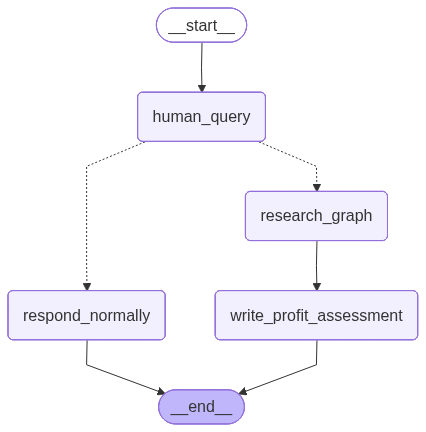

Visualizing the Research subgraph


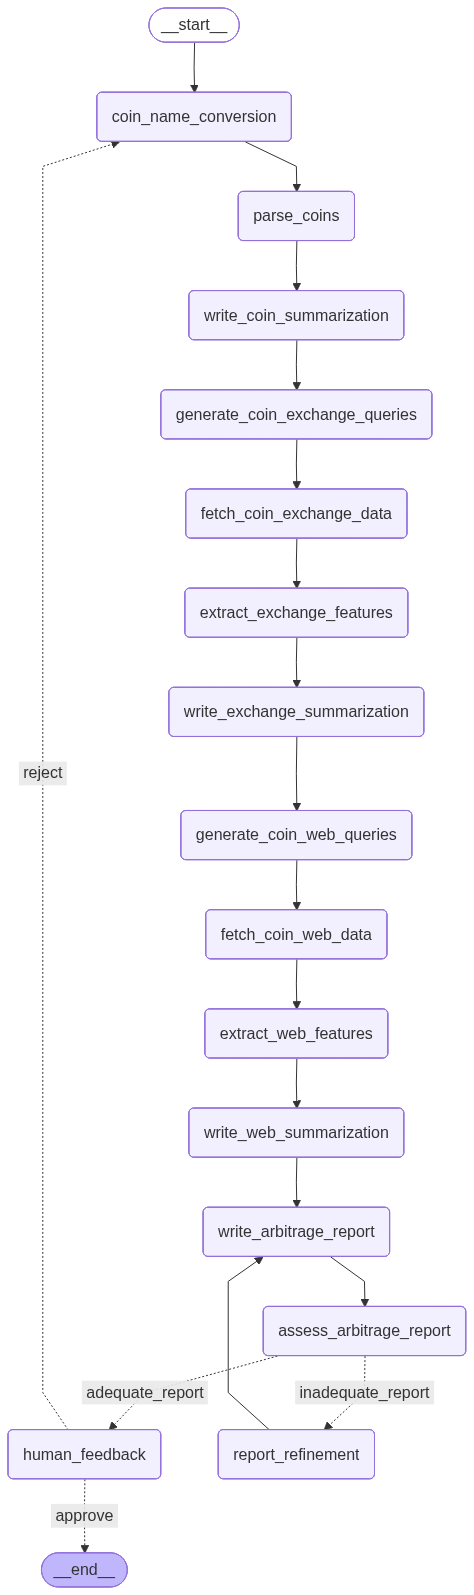

In [34]:
print("Visualizing the Graph")
display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

print("Visualizing the Research subgraph")
research_app = research_graph.compile()

display(
    Image(
        research_app.get_graph().draw_mermaid_png()
    )
)


### Run the Application

In [35]:
def run_arbitrage_agent(query: str = "") -> Dict[str, str]:
    thread_id = str(uuid.uuid4())
    config = {"configurable": {"thread_id": thread_id, "recursion_limit": 100}}
    results = app.invoke({"query": query}, config)
    return {
        "query": query,
        "decision": results.get("decision", ""),
        "risk_level": results.get("risk_level", ""),
        "arbitrage_score": f"{results.get('arbitrage_score', '')}",
        "human_decision": results.get("human_decision", ""),
        "exchange_suggestions": results.get("exchange_suggestions", {}),
        "report": results.get("report", ""),
        "arbitrage_report": results.get("arbitrage_report", ""),
    }

### Test the Agent

In [36]:
query = "Assess arbitrage opportunties: TON, PEPE, WLD"
results = run_arbitrage_agent(query)
print(f"Query: {query}")
print(f"Last Decision: {results['decision']}")
print(f"Risk: {results['risk_level']}")
print(f"Arbitrage Score: {results['arbitrage_score']}")
print(f"Exchange Suggestions: {results['exchange_suggestions']}")
print(f"Report:\n{results['report']}\n")
print(f"Arbitrage Report:\n{results['arbitrage_report']}\n")

ROUTE_QUERY: evaluating query='Assess arbitrage opportunties: TON, PEPE, WLD...'
ROUTE_QUERY: model='arbitrage', route='research_graph'
Converted coin names to tickers: ['TON', 'PEPE', 'WLD']

PARSE_COINS: START - symbols=['TON', 'PEPE', 'WLD'], existing_coin_ids keys=[]
PARSE_COINS: Fetching CoinGecko coin list...
PARSE_COINS: Got 19136 coins from CoinGecko
PARSE_COINS: Mapping 3 symbols to CoinGecko IDs
  TON -> tac-bridged-ton-tac
  PEPE -> baby-pepe-5
  WLD -> worldcoin-wld
PARSE_COINS: END - Successfully mapped 3/3 coins
PARSE_COINS: Returning coin_ids keys=['TON', 'PEPE', 'WLD']
PARSE_COINS: Returning parsed_coins count=3
GENERATE_COIN_EXCHANGE_QUERIES: symbols=['TON', 'PEPE', 'WLD'], parsed_coins=3
FETCH_COIN_EXCHANGE_DATA: parsed_coins=3, symbols=['TON', 'PEPE', 'WLD']
Retrieved 2 tickers for TON
Retrieved 1 tickers for PEPE
Retrieved 100 tickers for WLD
EXTRACT_EXCHANGE_FEATURES: Processing 103 exchange data points
  Analyzing 2 exchanges for TON
  Analyzing 1 exchanges for PE

In [38]:
query = "Who painted the Mona Lisa? When and where was it painted?"
results = run_arbitrage_agent(query)
print(f"Query: {query}")
print(f"Response:\n{results['arbitrage_report']}\n")

ROUTE_QUERY: evaluating query='Who painted the Mona Lisa? When and where was it painted?...'
ROUTE_QUERY: model='normal', route='respond_normally'
RESPOND_NORMALLY: answering non-arbitrage query='Who painted the Mona Lisa? When and where was it painted?...'
Query: Who painted the Mona Lisa? When and where was it painted?
Response:
The Mona Lisa was painted by the Italian artist Leonardo da Vinci. It's believed to have been painted between 1503 and 1506, in Florence, Italy, and then completed later in France, around 1517, in the Château du Clos Lucé, Amboise.

